# LeakyBucket model BMI demo

In this notebook we demonstrate the leakybucket Basic Model Interface. This BMI has the following model structure implemented:

<img src="diagram.png" alt="diagram" width="200"/>

The implementation can be found in `src/leakybucket/leakybucket_bmi.py`

To be able to initialize the BMI, we need a configuration file which contains the "leakiness" parameter, as well as the forcing file locations.

For forcing we use the eWaterCycle generic forcing generator. This can generate forcing data with ESMValTool from ERA5 data (if available on your machine), as well as CMIP6 data (which will be downloaded automatically).

In [1]:
from leakybucket.leakybucket_bmi import LeakyBucketBmi
from ewatercycle.base.forcing import GenericLumpedForcing
import ewatercycle
from pathlib import Path
import pandas as pd
import numpy as np

shapeObject = Path(ewatercycle.__file__).parent / "testing/data/Rhine/Rhine.shp"

cmip_dataset = {
    "dataset": "EC-Earth3",
    "project": "CMIP6",
    "grid": "gr",
    "exp": "historical",
    "ensemble": "r6i1p1f1",
}

cmip_forcing = GenericLumpedForcing.generate(
    dataset=cmip_dataset,
    start_time="2010-01-01T00:00:00Z",
    end_time="2010-12-31T00:00:00Z",
    shape=shapeObject,
)

/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


Now we have the forcing data available we can prepare the configuration file:

In [2]:
experiment_config_file = f"""{{
    "precipitation_file": "{cmip_forcing["pr"]}",
    "temperature_file": "{cmip_forcing["tas"]}",
    "leakiness": 0.05
}}
"""

with open("experiment_leakybucket_config.json", "w") as f:
    f.write(experiment_config_file)

With the configuration file ready, we can define the model and initialize it. To clearly indicate that we are creating an instance of the class ```LeakyBucketBMI``` we use ```experiment_model``` as the name for the model object for this (demo) experiment.

In [3]:
experiment_model = LeakyBucketBmi()
experiment_model.initialize(config_file="experiment_leakybucket_config.json")

We can now use the `.update()` method to advance the model one time step.
After updating the model, we can request the current discharge using `.get_value("discharge")`.

We store this discharge in a list. For plotting, we also request the current model time (which is in seconds since 1970), and covert that to a pandas Timestamp.

In [4]:
discharge = []
time = []
while experiment_model.get_current_time() < experiment_model.get_end_time():
    
    #run the model for one timestep
    experiment_model.update()

    #get the discharge output of the model. Note that this is an numpy array (of length 1)
    discharge_this_timestep = experiment_model.get_value("discharge", np.array([0.]))

    #add this discharge to a list
    discharge.append(discharge_this_timestep[0])

    #add the timestamp to a list
    time.append(pd.Timestamp(experiment_model.get_current_time(), unit="s"))

Now we can plot our hydrograph.

Note that the unit of discharge is in mm/d. Conversion to m3/s requires the area of the catchment.

Text(0.5, 0, 'Time')

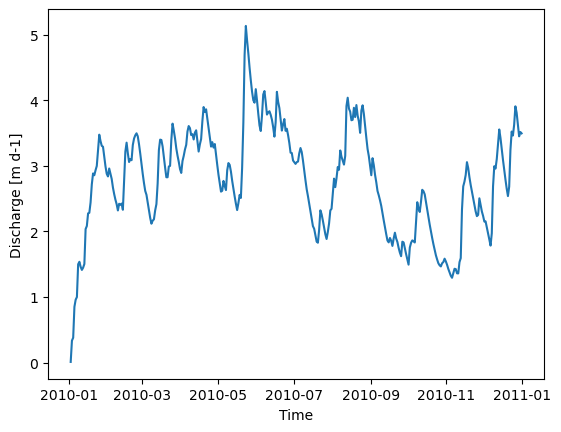

In [5]:
import matplotlib.pyplot as plt
plt.plot(time, discharge)

plt.ylabel(f"Discharge [{experiment_model.get_var_units('discharge')}]")
plt.xlabel("Time")

It is good practice to remove a model object when done using ```.finalize()```. For small models like this, it doesn't matter too much, but larger models that run in containers keep using resources when not ```finalized```.

In [6]:
experiment_model.finalize()